# Temperature averaged over RNO-G antenna patterns

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from NuRadioReco.utilities.geometryUtilities import get_fresnel_r_p, get_fresnel_r_s
from scipy.interpolate import interp1d
from functools import lru_cache

from temperature_profiles import temperature_profile_grip
grip = temperature_profile_grip()

In [2]:
from ice_integrator import get_trace
@lru_cache(maxsize=1000)
def temperature_integral(zenith, z_antenna):
    # get the track for respective zenith direction
    # (distance vs depth)
    radius, depth_raytracing, distance_raytracing, reflected_power = get_trace(zenith, z_antenna)
    # get the temperature at each of the track points
    depth_interp = interp1d(distance_raytracing, depth_raytracing, fill_value="extrapolate")
    power_interp = interp1d(distance_raytracing, reflected_power, fill_value="extrapolate")
    
    distance = np.linspace(0,30000,300000)
    depth = depth_interp(distance)
    ref = power_interp(distance)
    
    l_att = grip.attenuation_from_depth(depth)
    meaned_l_att = np.cumsum(l_att)/np.cumsum(np.ones_like(distance))
    ##print(meaned_l_att)
    
    att_factor = np.exp(-distance/meaned_l_att)
    T_env = grip.profile(depth)+273.15 # Celsius to Kelvin
    
    return np.sum((ref*att_factor*T_env/l_att/10))


In [3]:
thetas = np.concatenate([np.linspace(0, 180,31), np.linspace(25,50,26)])
thetas = list(set(thetas))
thetas.sort()

temperatures = {}
for z_antenna in [-3, -10, -50, -100, -150]:
    print(f"calculating for {z_antenna}m deep antenna")
    temperatures[z_antenna] = []
    for theta in thetas:
        temperatures[z_antenna].append(temperature_integral(theta, z_antenna=z_antenna))

calculating for -3m deep antenna
calculating for -10m deep antenna
calculating for -50m deep antenna
calculating for -100m deep antenna
calculating for -150m deep antenna


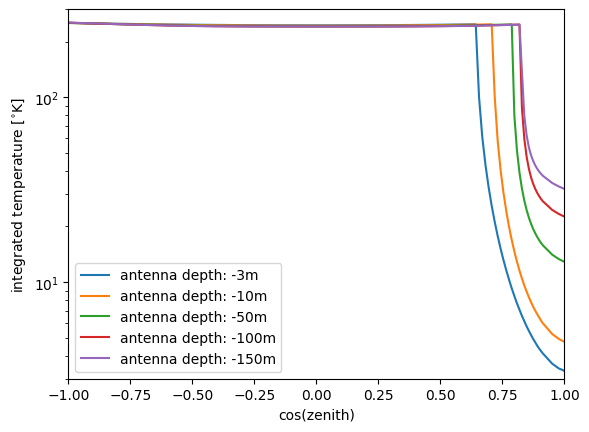

In [4]:
for z_antenna in temperatures:
    plt.plot(np.cos(np.radians(thetas)), temperatures[z_antenna], "-", label=f"antenna depth: {z_antenna}m")
#plt.plot(thetas2, T2, "o-")
plt.xlabel("cos(zenith)")
plt.ylabel(r"integrated temperature [$^{\circ}$K]")
plt.legend()
plt.ylim(3,3e2)
plt.xlim(-1,1)
plt.semilogy()
plt.savefig("log_temperature_vs_antenna_cos_zenith_different_depths.pdf")

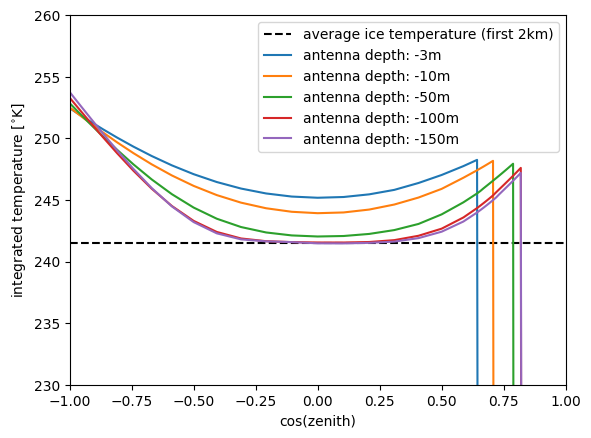

In [5]:
plt.axhline(np.mean(grip.profile(np.linspace(0,-2000,2000)))+273.15, linestyle="--", color="black", label="average ice temperature (first 2km)")
for z_antenna in temperatures:
    plt.plot(np.cos(np.radians(thetas)), temperatures[z_antenna], "-", label=f"antenna depth: {z_antenna}m")
#plt.plot(thetas2, T2, "o-")
plt.xlabel("cos(zenith)")
plt.ylabel(r"integrated temperature [$^{\circ}$K]")
plt.legend()
plt.ylim(230,260)
plt.xlim(-1,1)
plt.savefig("temperature_vs_antenna_cos_zenith_different_depths.pdf")


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from NuRadioReco.framework.base_trace import BaseTrace
from NuRadioReco.utilities import units

from NuRadioReco.detector import detector
import datetime
det = detector.Detector(json_filename="RNO_G/RNO_season_2022.json", antenna_by_depth=False)
det.update(datetime.datetime.now())

from NuRadioReco.detector import antennapattern
antenna_response = antennapattern.AntennaPatternProvider()

from NuRadioReco.utilities import trace_utilities
from NuRadioReco.utilities import ice
from NuRadioReco.utilities import geometryUtilities as geo_utl

@lru_cache(maxsize=500)
def vel_data_for_channel(channel, frequencies = 100*units.MHz):
    response = antenna_response.load_antenna_pattern(det.get_antenna_model(21, channel))

    #fig, ax = plt.subplots(1,1,sharex=True, sharey=True, figsize=(12,12))

    zenith = np.arccos(np.linspace(-1,1,100))
    azimuth = np.linspace(0, 2*np.pi,100)

    for ci, channel_id in enumerate([channel]):
        #print(f"calculating response for channel {channel_id}")
        r = []
        for z in zenith:
            for a in azimuth:
                antenna_pattern = response
                ori = det.get_antenna_orientation(21, channel_id)
                VEL = antenna_pattern.get_antenna_response_vectorized(frequencies, z, a, *ori)
                efield_antenna_factor = np.array([VEL['theta'] , VEL['phi']])
                vel = np.sum(abs(efield_antenna_factor)**2)**0.5
                r.append({"zenith": z, "azimuth": a, "res": vel})
    return pd.DataFrame(r)

def effective_temperature_for_channel(channel, depth=-100, frequencies=100*units.MHz):
    df = vel_data_for_channel(channel, frequencies=frequencies)
    temps_env = [temperature_integral(np.degrees(zenith), z_antenna=depth) for zenith in list(df.zenith)]
    return np.sum(np.array(temps_env)*np.array(df.res)**2)/np.sum(np.array(df.res)**2)

In [11]:
for cc, dd in zip([4,4],[-15,-100]):
    teff = effective_temperature_for_channel(cc, depth=dd)
    print(f"channel {cc}, depth {dd}m, effective temperature {np.round(teff, 2)} Kelvin")

channel 4, depth -15m, effective temperature 234.17 Kelvin
channel 4, depth -100m, effective temperature 238.64 Kelvin


In [13]:
# This calculates the frequency dependence of the effective ice noise temperature for an LPDA

frequencies = np.linspace(50,550,100)*units.MHz

teffs = []
for f in frequencies:
    for cc, dd in zip([13],[-3]):
        teff = effective_temperature_for_channel(cc, depth=dd, frequencies=f)
        print(f"frequency {np.round(f*1e3,2)} MHz, channel {cc}, depth {dd}m, effective temperature {np.round(teff,2)} Kelvin")
        teffs.append(teff)
    

frequency 50.0 MHz, channel 13, depth -3m, effective temperature 188.78 Kelvin
frequency 55.05 MHz, channel 13, depth -3m, effective temperature 184.43 Kelvin
frequency 60.1 MHz, channel 13, depth -3m, effective temperature 178.41 Kelvin
frequency 65.15 MHz, channel 13, depth -3m, effective temperature 170.1 Kelvin
frequency 70.2 MHz, channel 13, depth -3m, effective temperature 158.86 Kelvin
frequency 75.25 MHz, channel 13, depth -3m, effective temperature 144.63 Kelvin
frequency 80.3 MHz, channel 13, depth -3m, effective temperature 129.95 Kelvin
frequency 85.35 MHz, channel 13, depth -3m, effective temperature 119.99 Kelvin
frequency 90.4 MHz, channel 13, depth -3m, effective temperature 117.32 Kelvin
frequency 95.45 MHz, channel 13, depth -3m, effective temperature 119.68 Kelvin
frequency 100.51 MHz, channel 13, depth -3m, effective temperature 123.76 Kelvin
frequency 105.56 MHz, channel 13, depth -3m, effective temperature 127.47 Kelvin
frequency 110.61 MHz, channel 13, depth -3m,

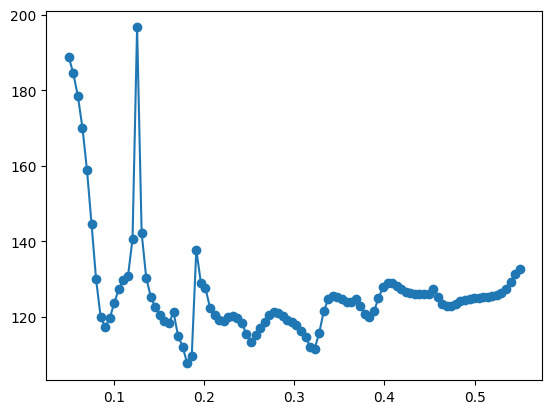

In [14]:
plt.plot(frequencies, teffs, "o-")

In [18]:
def vel_for_channel(channel, depth=-100, frequencies=100*units.MHz):
    df = vel_data_for_channel(channel, frequencies=frequencies)

    return np.mean(np.array(df.res)**2)

frequencies = np.linspace(50,550,51)*units.MHz

vel = []
for f in frequencies:
    for cc, dd in zip([13],[-3]):
        vel_eff = vel_for_channel(cc, depth=dd, frequencies=f)
        print(f"channel {cc}, depth {dd}:", vel_eff)
        vel.append(vel_eff)

channel 13, depth -3: 0.01458759796153011
channel 13, depth -3: 0.04464317930407758
channel 13, depth -3: 0.10649108507697638
channel 13, depth -3: 0.10284447592415345
channel 13, depth -3: 0.07485619836884183
channel 13, depth -3: 0.06518812721598945
channel 13, depth -3: 0.05221543325170636
channel 13, depth -3: 0.041232397974781995
channel 13, depth -3: 0.03913312083517331
channel 13, depth -3: 0.031125950251710582
channel 13, depth -3: 0.028489758181232963
channel 13, depth -3: 0.02676313214925392
channel 13, depth -3: 0.02340275320480206
channel 13, depth -3: 0.02119089355163489
channel 13, depth -3: 0.018245881978433777
channel 13, depth -3: 0.016521548211222946
channel 13, depth -3: 0.01425477596043794
channel 13, depth -3: 0.013652486463341069
channel 13, depth -3: 0.013066188647026123
channel 13, depth -3: 0.011865613708839507
channel 13, depth -3: 0.010568381390706594
channel 13, depth -3: 0.00982184342162221
channel 13, depth -3: 0.009309361706868672
channel 13, depth -3: 0.

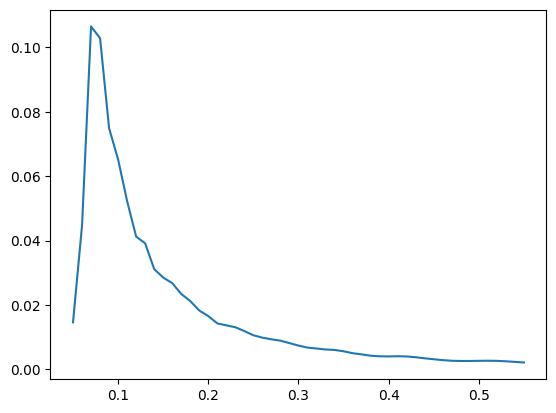

In [19]:
plt.plot(frequencies, vel)
#plt.semilogy()